# Imports

In [1]:
import sys
from cycler import cycler
from pprint import pprint
import numpy as np
import matplotlib
from matplotlib import pyplot as plt, animation
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys')
from tools import plotting as myplt
from tools import envelope_analysis as ea
from tools.utils import list_files, show

# Settings

In [2]:
plt_kws = dict(legend=False, xlabel='s / L')
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None 
cmap = plot.Colormap('viridis')
dpi=500

output_dir = '_output/data/'

# Read Data

In [3]:
transfer_mats_master_list = [np.load('_output/data/transfer_mats{}.npy'.format(i)) for i in range(4)]
tracked_params_master_list = [np.load('_output/data/tracked_params_list{}.npy'.format(i)) for i in range(4)]
positions_master_list = [np.loadtxt('_output/data/positions{}.txt'.format(i)) for i in range(4)]
perveances = np.loadtxt('_output/data/perveances.dat')
mode = int(np.loadtxt('_output/data/mode.txt'))

In [4]:
lattice_names = [
    'FODO',
    'FODO\n(split tunes)',
    'FODO\n(skew quads)',
    'FODO\n(solenoid insert)'
]

In [5]:
_cycler = cycler('color', [cmap(i) for i in np.linspace(0, 1, len(perveances))])

# Transfer matrix 

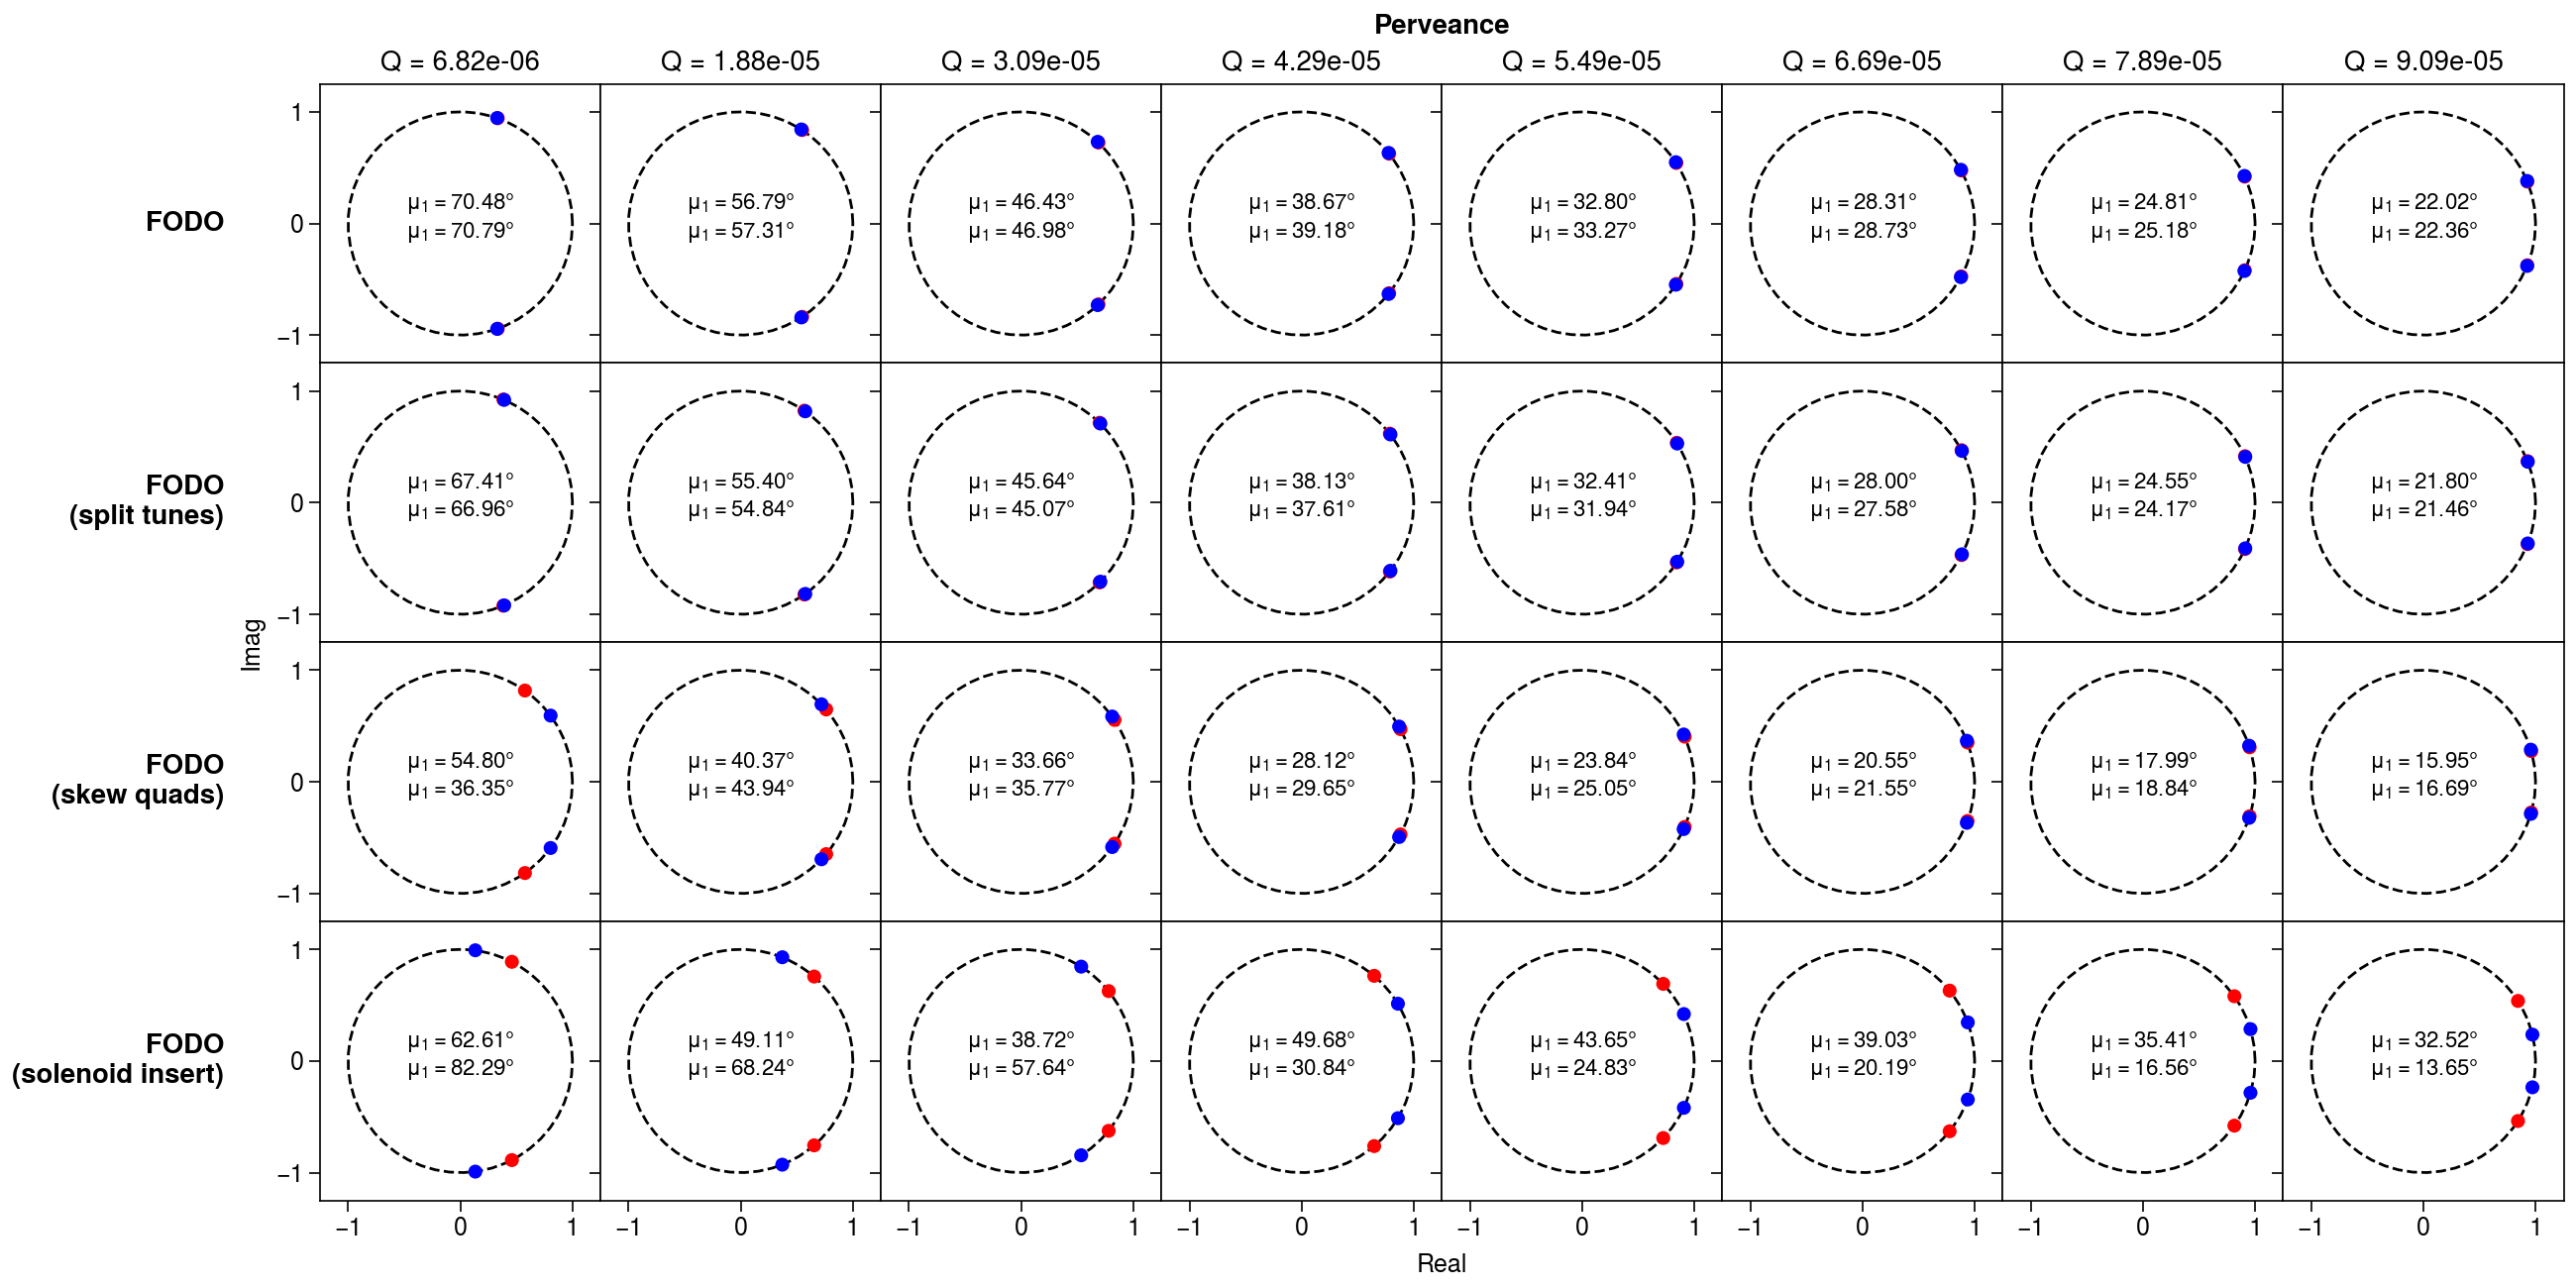

In [18]:
nrows, ncols = 4, len(perveances)
s = 20
fontsize=8

fig, axes = plot.subplots(nrows=nrows, ncols=ncols, figsize=(13, 6.5), hspace=0, wspace=0)
myplt.set_labels(axes[0, :], ['Q = {:.2e}'.format(Q) for Q in perveances], 'title')

# Plot unit circle in background
psi = np.linspace(0, 2*np.pi, 50)
x_circle, y_circle = np.cos(psi), np.sin(psi)
for ax in axes:
    ax.plot(x_circle, y_circle, 'k--', lw=1, zorder=0)
    
# Plot eigenvalues
for i, transfer_mats in enumerate(transfer_mats_master_list):
    for ax, M in zip(axes[i, :], transfer_mats):
        eigvals, eigvecs = np.linalg.eig(M)
        ax.scatter(eigvals.real, eigvals.imag,  s=s, c=('r', 'r', 'b', 'b'), zorder=1)
        mu1, _, mu2, _ = np.degrees(np.arccos(eigvals.real))
        split, fontsize = 0.05, 8
        ax.annotate(r'$\mu_1 = {:.2f}\degree$'.format(mu1), xy=(0.5, 0.5+split), 
                    xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)
        ax.annotate(r'$\mu_1 = {:.2f}\degree$'.format(mu2), xy=(0.5, 0.5-split), 
                    xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)
        
# Formatting
scale = 1.25
axes.format(
    suptitle='Perveance', grid=False,
    xlim=(-scale, scale), ylim=(-scale, scale), xlabel='Real', ylabel='Imag',
    xticks=[-1, 0, 1], yticks=[-1, 0, 1],
    rowlabels=lattice_names, 
    xminorlocator='null', yminorlocator='null'
)
        
plt.savefig('_output/figures/eigvals.png', dpi=dpi, facecolor='w')

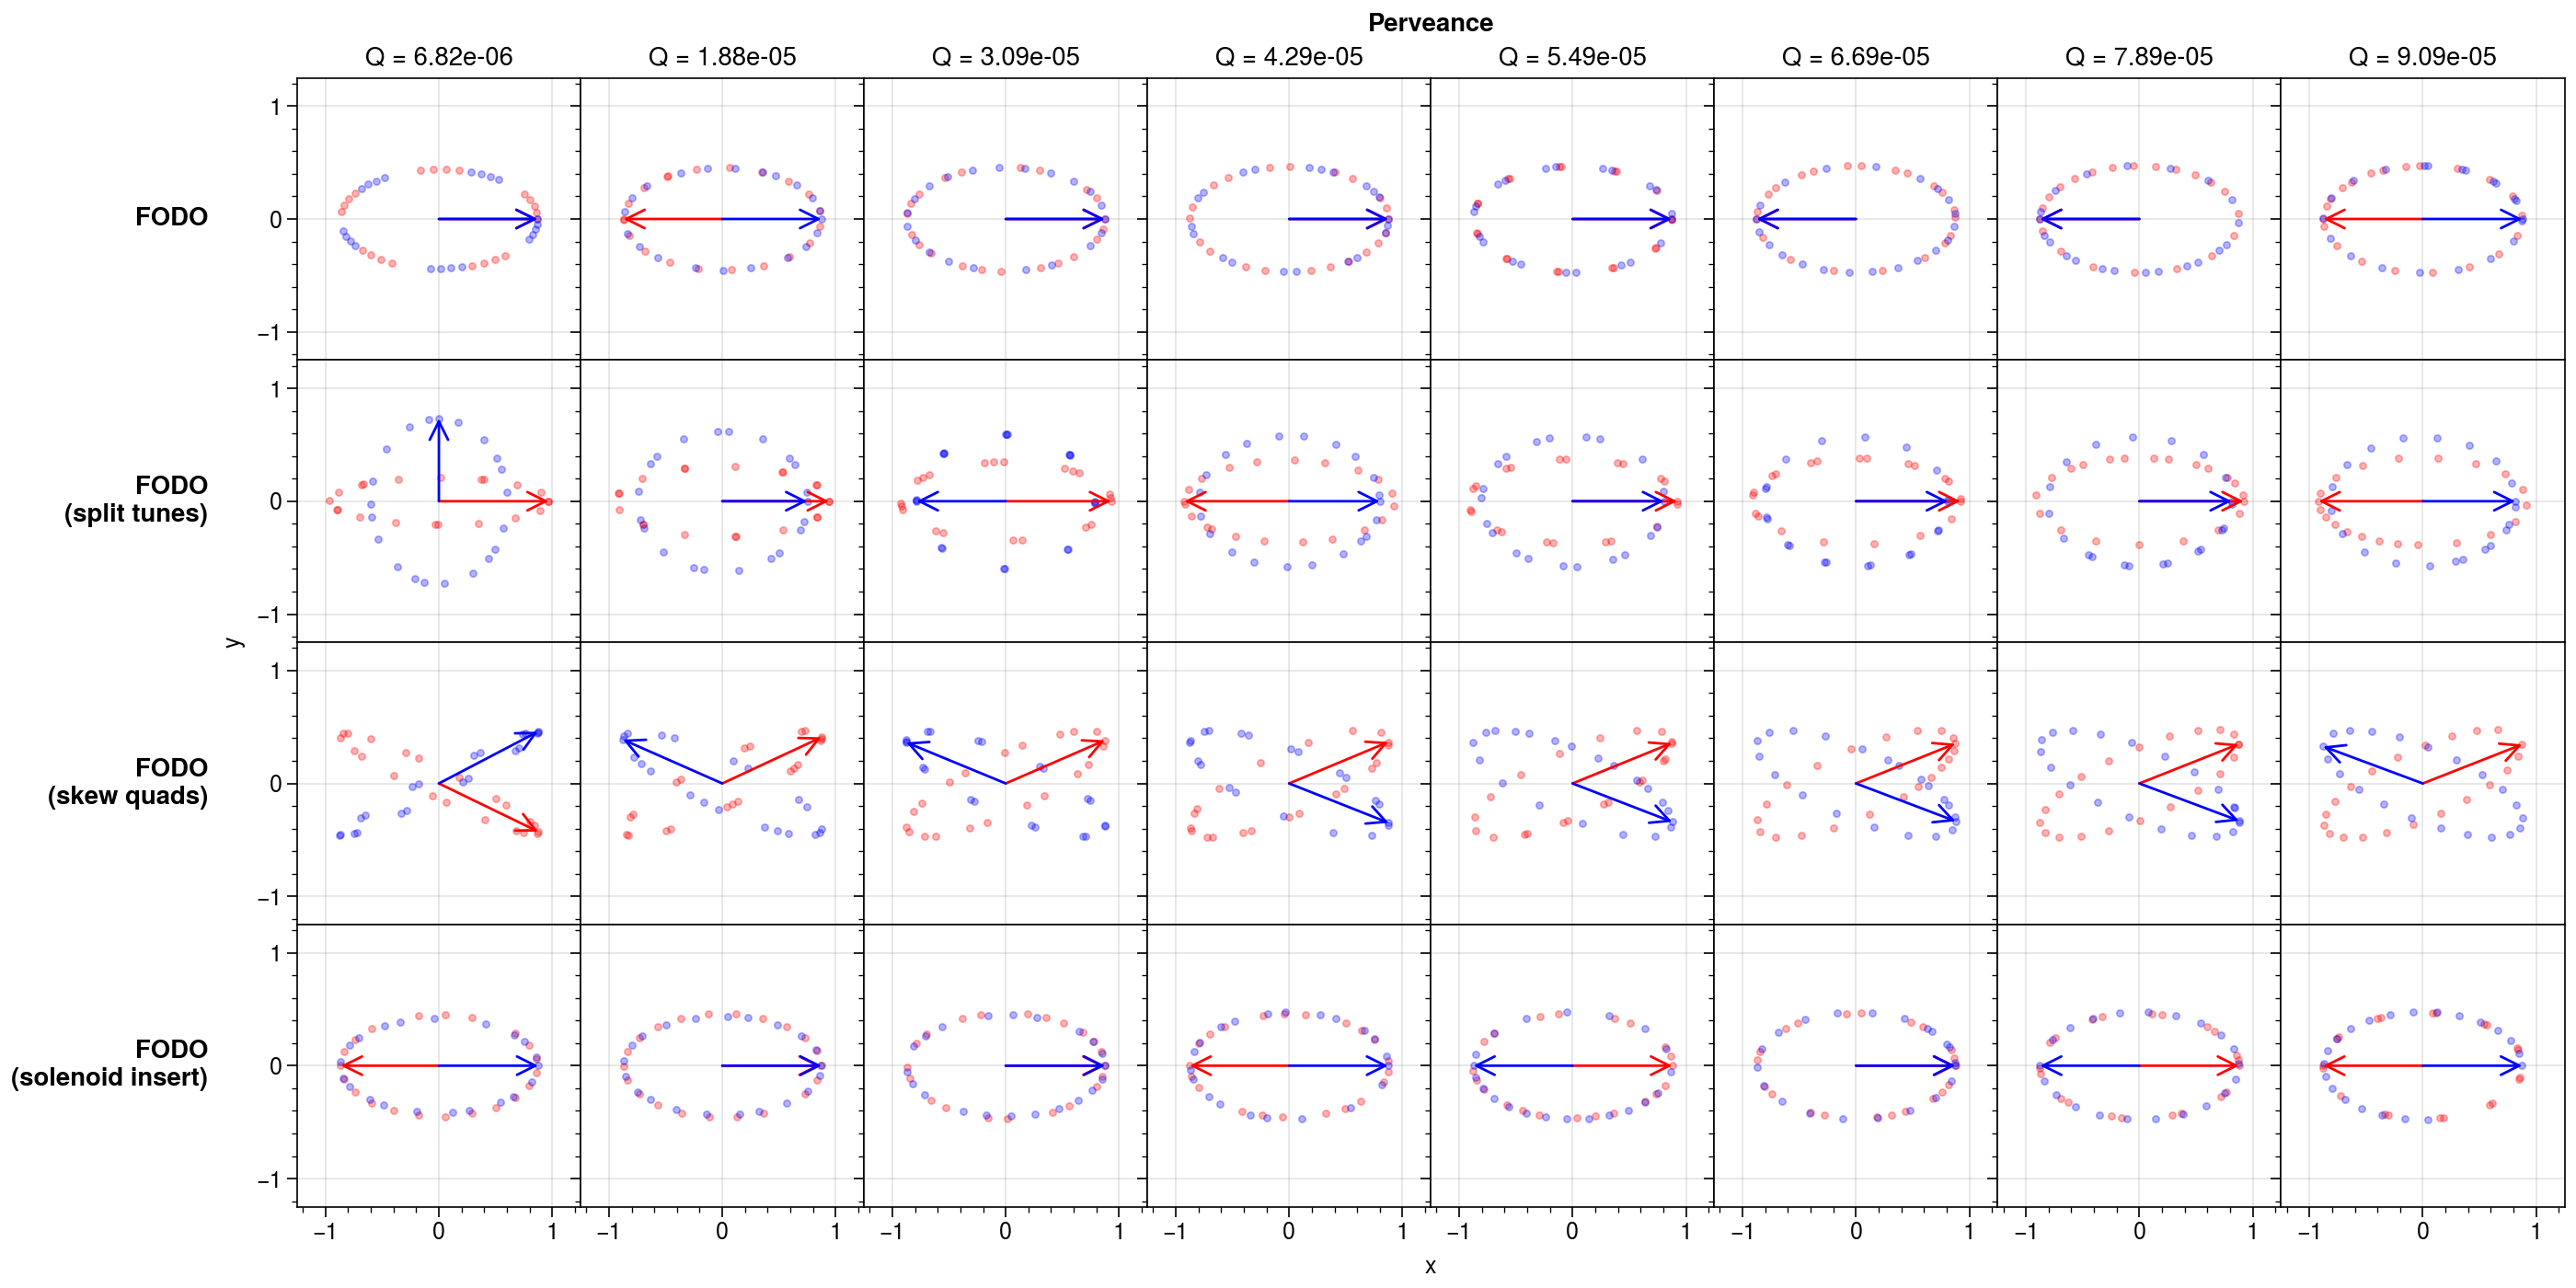

In [19]:
fig, axes = plot.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7), hspace=0, wspace=0)
myplt.set_labels(axes[0, :], ['Q = {:.2e}'.format(Q) for Q in perveances], 'title')
scale = 1.25
axes.format(
    suptitle='Perveance',
    xlim=(-scale, scale), ylim=(-scale, scale), 
    xlabel='x', ylabel='y',
    xticks=[-1, 0, 1], yticks=[-1, 0, 1],
    leftlabels=lattice_names, 
)
for i in range(nrows):
    for ax, M in zip(axes[i, :], transfer_mats_master_list[i]):
        myplt.eigvec_trajectory(ax, M, 'x', 'y', s=7, lw=1)
        
plt.savefig('_output/figures/eigvecs.png', dpi=dpi, facecolor='w')

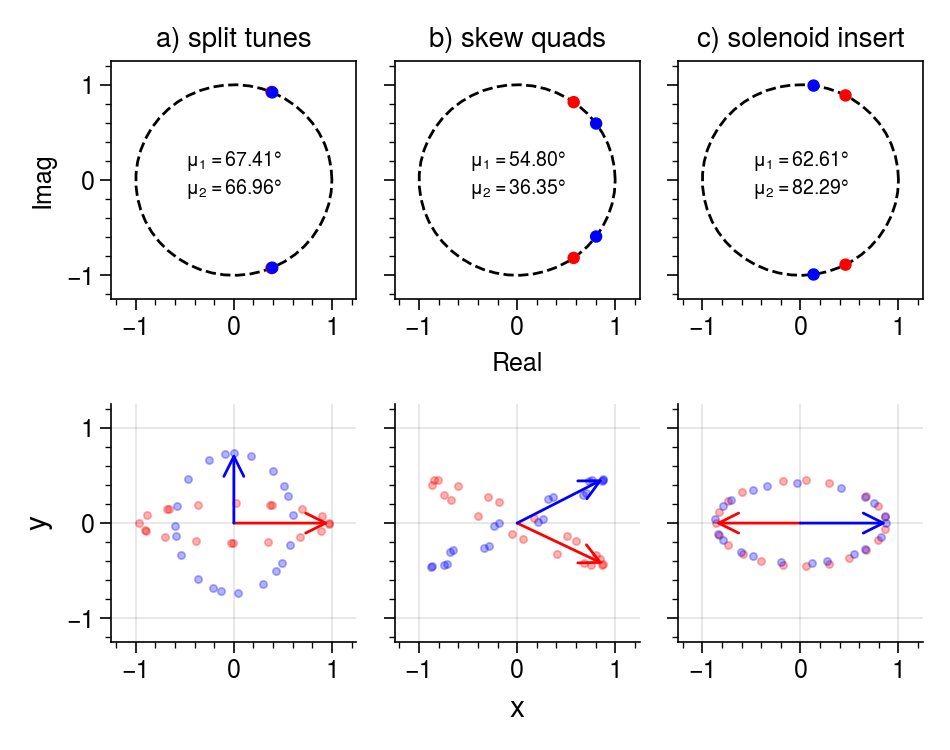

In [20]:
transfer_mats = np.array(transfer_mats_master_list)[[1, 2, 3], 0] # fodo_split, fodo_skew, fodo_sol at zero space charge

fig, axes = plt.subplots(2, 3, figsize=(4.75, 3.75), sharex='row', sharey='row', tight_layout=True)

for (ax1, ax2), M in zip(axes.T, transfer_mats):
    eigvals, eigvecs = np.linalg.eig(M)
    ax1.plot(x_circle, y_circle, 'k--', lw=1, zorder=0)
    ax1.scatter(eigvals.real, eigvals.imag,  s=15, c=('r', 'r', 'b', 'b'), zorder=1)
    myplt.eigvec_trajectory(ax2, M, 'x', 'y', s=7, lw=1)
    mu1, _, mu2, _ = np.degrees(np.arccos(eigvals.real))
    split, fontsize = 0.06, 7
    ax1.annotate(r'$\mu_1 = {:.2f}\degree$'.format(mu1), xy=(0.5, 0.5+split), xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)
    ax1.annotate(r'$\mu_2 = {:.2f}\degree$'.format(mu2), xy=(0.5, 0.5-split), xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)

myplt.set_labels(axes[0, :], ['a) split tunes','b) skew quads','c) solenoid insert'], 'title')
myplt.set_limits(axes.flat, 6*[(-scale, scale)], 'xy')
myplt.toggle_grid(axes[0, :], 'off')
myplt.despine(axes[1, :], ('top', 'right'))
axes[0, 1].set_xlabel('Real')
axes[0, 0].set_ylabel('Imag')
axes[1, 1].set_xlabel(r'$x$', fontsize='large')
axes[1, 0].set_ylabel(r'$y$', fontsize='large')
    
plt.savefig('_output/figures/subplots.png', dpi=dpi, facecolor='w')

# Beam statistics

In [9]:
stats_master_list = []

for tracked_params_list, positions in zip(tracked_params_master_list, positions_master_list):
    stats_list = []
    for tracked_params in tracked_params_list:
        stats = ea.Stats(mode)
        stats.read_env(tracked_params)
        for df in stats.dfs():
            df['s'] = positions
            df['s/L'] = positions / positions[-1]
        stats_list.append(stats)
    stats_master_list.append(stats_list)

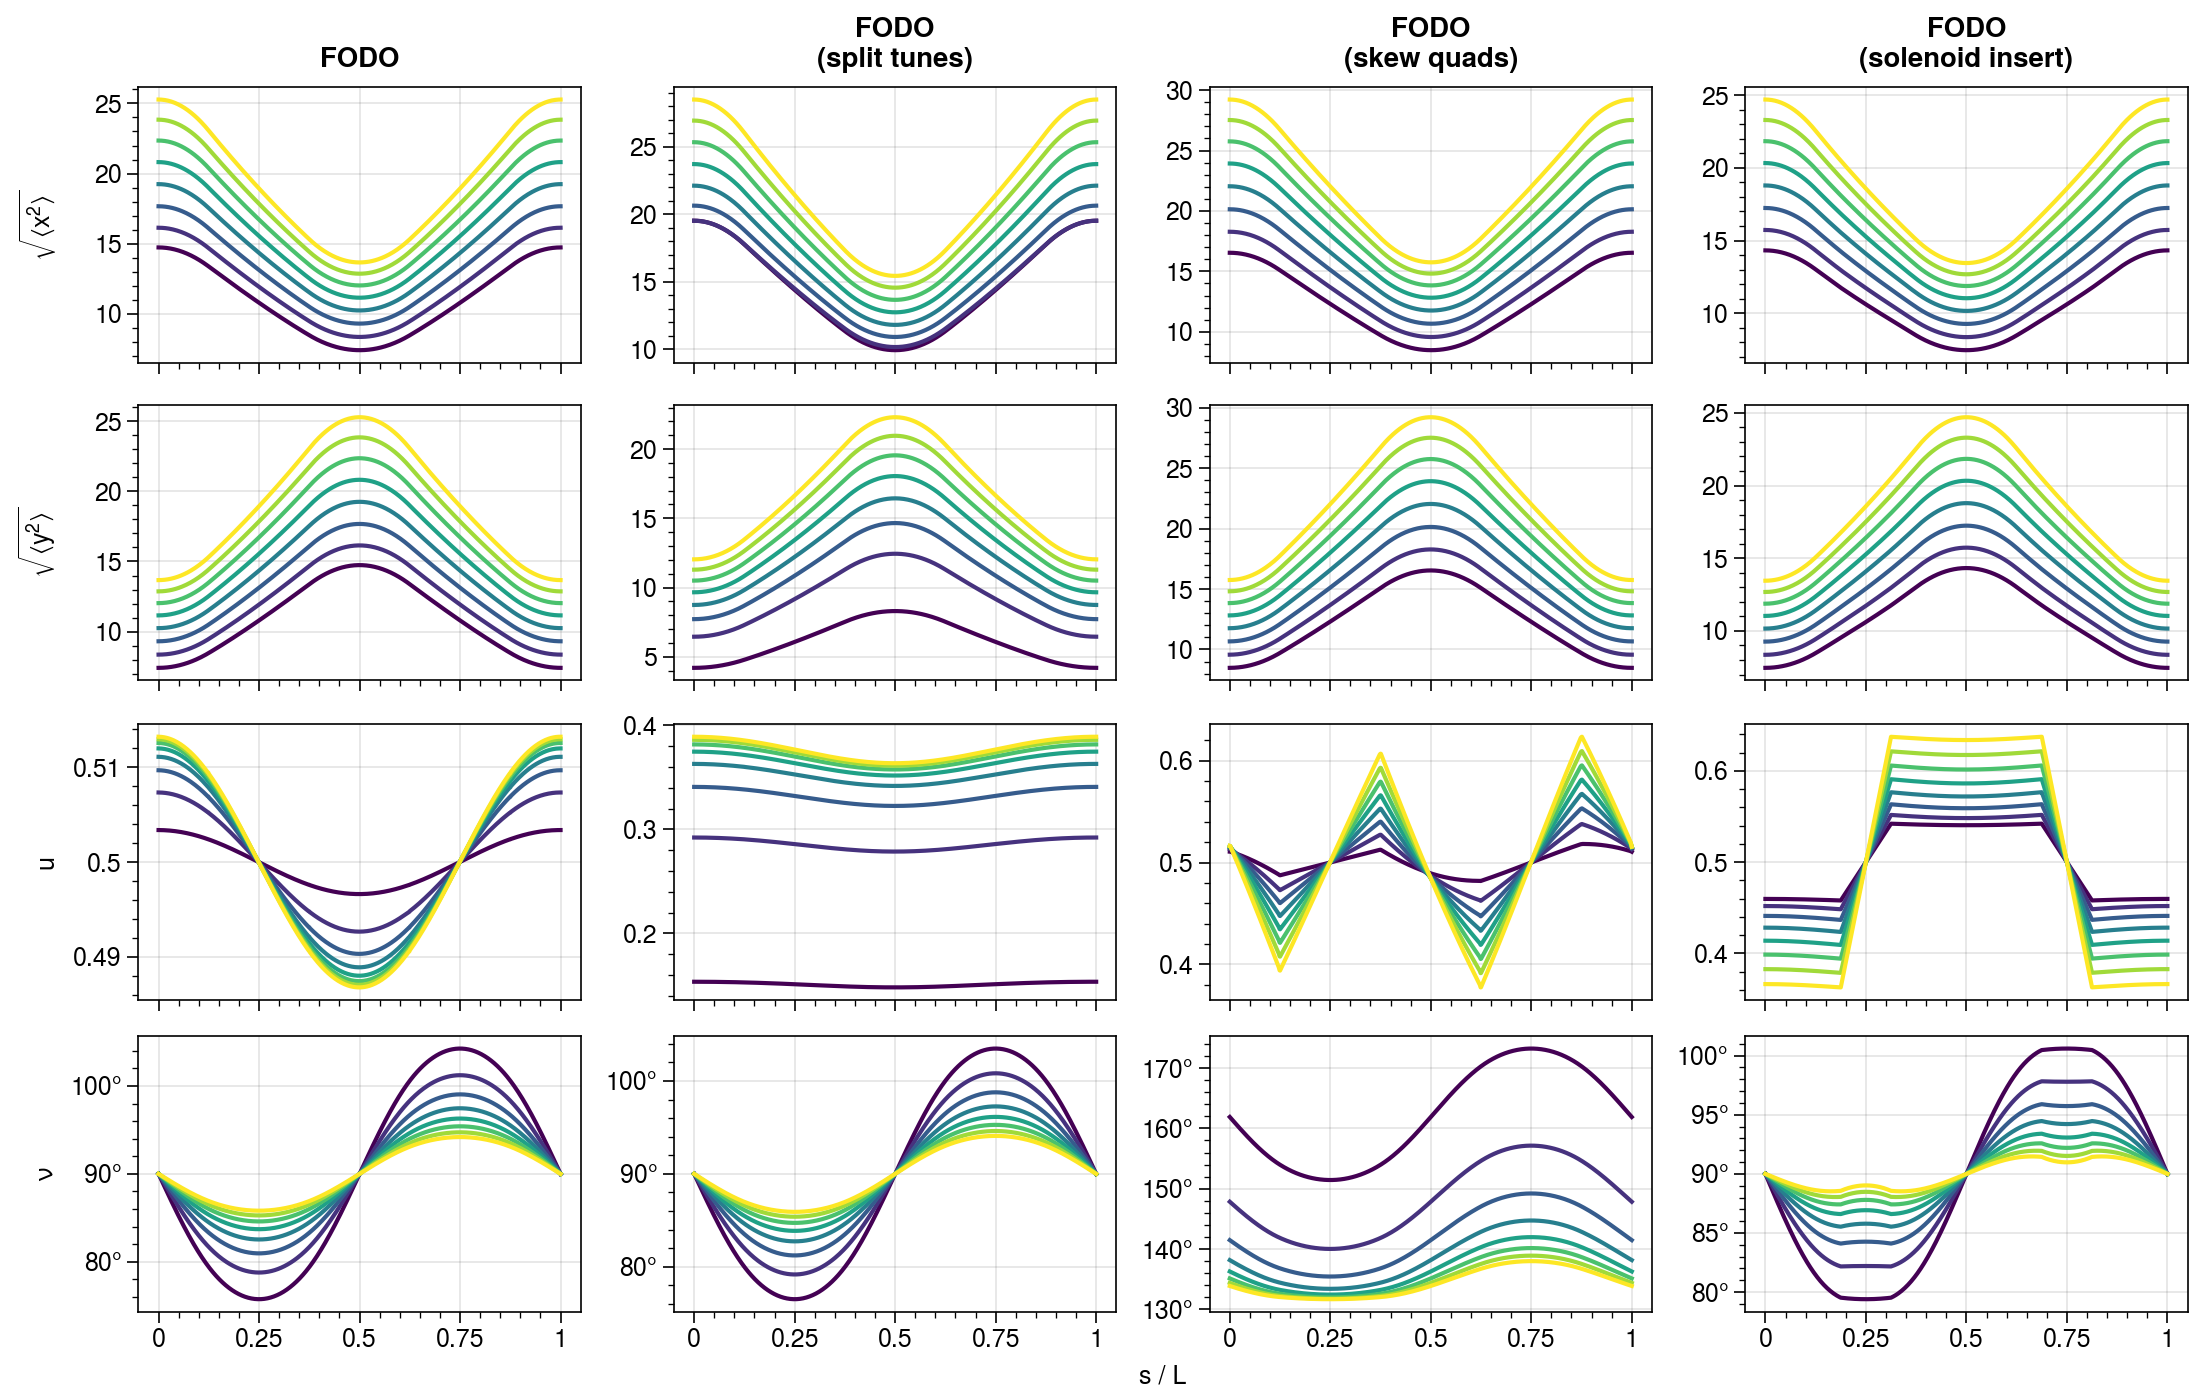

In [17]:
fig, axes = plot.subplots(ncols=len(stats_master_list), nrows=4, figsize=(11, 7), spany=False, aligny=True, sharey=False)
axes.set_prop_cycle(_cycler)

for i, stats_list in enumerate(stats_master_list):
    for stats in stats_list:
        eps = max(stats.twiss4D.loc[0, 'e1'], stats.twiss4D.loc[0, 'e2'])
        stats.twiss4D['xrms'] = np.sqrt(eps * stats.twiss4D['bx'])
        stats.twiss4D['yrms'] = np.sqrt(eps * stats.twiss4D['by'])
        for ax, col in zip(axes[:, i], ['xrms', 'yrms', 'u', 'nu']):
            stats.twiss4D[['s/L', col]].plot('s/L', ax=ax, **plt_kws)

myplt.set_labels(axes[:, 0], [r'$\sqrt{\langle{x^2}\rangle}$', r'$\sqrt{\langle{y^2}\rangle}$', 'u', r'$\nu$'], 'ylabel')
axes[3, :].format(yformatter='deg', toplabels=lattice_names)

plt.savefig('_output/figures/twissparams.png', dpi=500, facecolor='w')